### Initialize variables

In [1]:
lang = 'fi'
sg = 1
#architecture = 'mlp'
#architecture = 'cnn'
architecture = 'lstm'
#vector = 'word2vec_skipgram'
#vector = 'word2vec_cbow'
#vector = 'spacy'
vector = 'tfkerastokenizer'
#vector = 'tfidf_hashing_vectorizer'
#optimizer_name = 'sgd'
optimizer_name = 'adam'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/final/enron_sent/'

import os
global PATH
PATH = os.getcwd() + '/'

!pip install import-ipynb -q
import import_ipynb

import include as i
spacy_path = i.spacy_paths[lang]
stopwords_lang = i.stopwords_langs[lang]

/content/drive/MyDrive/Colab Notebooks/final/enron_sent
     |████████████████████████████████| 1.6 MB 5.1 MB/s 
importing Jupyter notebook from include.ipynb


### Initialize libraries

In [4]:
import base64
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import string
import tensorflow as tf
import time

import nltk
nltk.download('stopwords')

import spacy

from collections import Counter
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential, Model
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import log_loss
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Accuracy,Precision,Recall,AUC,CategoricalAccuracy,CategoricalCrossentropy,CategoricalHinge
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

#https://stackoverflow.com/questions/49284455/keras-custom-function-implementing-jaccard
def jaccard_score(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac/100 * smooth

### Initialize language

In [6]:
from nltk.corpus import stopwords
stopwords = stopwords.words(stopwords_lang)

In [7]:
nlp = spacy.load(PATH + lang + spacy_path)

### Load data

In [ ]:
%%time
df_orig = pd.read_csv(PATH + 'data/users_as_labels_sent.csv')
# Use pickle to save space
#df_orig = pickle.load( open( PATH + 'data/df_' + lang, 'rb' ) ) # Preprocessed df
#df_orig = pickle.load( open( PATH + lang + '/data/df_' + lang, 'rb' ) ) # Ready df

CPU times: user 523 ms, sys: 243 ms, total: 766 ms
Wall time: 896 ms


In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39624 entries, 0 to 39623
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39624 non-null  object
 1   user    39624 non-null  object
 2   folder  39624 non-null  object
dtypes: object(3)
memory usage: 928.8+ KB


In [ ]:
df_orig.head()

,text,user,folder
0,\n I don't know if you got these.\n ----------...,bass-e,sent
1,\n Can you spell S-N-O-O-T-Y?\n \n e\n \n \n ...,bass-e,sent
2,"\n The new deal #s are 147888,147889.\n \n -E",bass-e,sent
3,\n I think I sent this to the worng e-mail add...,bass-e,sent
4,\n We are going to Woody's tonight if you are ...,bass-e,sent


In [ ]:
df_orig.user.value_counts()

mann-k          8926
kaminski-v      8644
dasovich-j      5366
germany-c       5128
shackleton-s    4407
jones-t         4123
bass-e          3030
Name: user, dtype: int64

In [ ]:
df = df_orig.copy()

### Translate

In [ ]:
df['lang'] = lang
df['length'] = df.text.apply(lambda x: len(x))

#### Do translate

In [ ]:
!pip install googletrans==3.1.0a0 -q

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 1.4 MB 11.0 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 


In [ ]:
from googletrans import Translator
translator = Translator()

In [ ]:
#Find if some features are too long for Google to translate
df.length.value_counts().sort_index(ascending=False)

In [ ]:
%%time
translations = []
for key in df.index:
  if key == 3430:
    line = line[:145900] # Experimentally established that max character limit Google can translate is ~145900
  else:
    line = df.text[key]
  translations.append(translator.translate(line, src = 'en', dest=lang).text)

In [ ]:
df['translation'] = translations
#df['translation'] = df.text # No need, because language already is EN

In [ ]:
df['length'] = df.translation.apply(lambda x: len(x))

#### Save translate

In [ ]:
# Use pickle to save space
pickle.dump(df, open(PATH + lang + '/data/df_' + lang, 'wb'))

#### Load translate

In [ ]:
df = pickle.load(open(PATH + lang + '/data/df_' + lang, 'rb'))

###Spacy

In [ ]:
#https://www.kaggle.com/code/enerrio/scary-nlp-with-spacy-and-keras/notebook

In [ ]:
# Clean text before feeding it to Spacy
punctuations = string.punctuation
from collections import defaultdict

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [ ]:
%%time
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', df.translation.shape)
train_cleaned = cleanup_text(df.translation, logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

In [ ]:
pickle.dump(train_cleaned, open(PATH + lang + '/texts/spacy_' + lang, 'wb'))

In [ ]:
train_cleaned = pickle.load(open(PATH + lang + '/texts/spacy_' + lang, 'rb'))

In [ ]:
df['translation_clean'] = train_cleaned.values

In [ ]:
df.translation_clean.isna().sum()

0

In [ ]:
df.translation_clean.fillna(' ', inplace=True)

In [ ]:
# Use pickle to save space
pickle.dump( df, open( PATH + lang + '/data/df_' + lang, 'wb' ) )

In [8]:
# Use pickle to save space
df = pickle.load( open( PATH + lang + '/data/df_' + lang, 'rb' ) )

In [ ]:
%%time
# Parse documents and print some info
print('Parsing documents...')

train_vec = []
c = 0
for doc in nlp.pipe(df.translation_clean, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((300,), dtype="float32"))
    if c%100 == 0: print(f'c: {c}')
    c+=1
        
# train_vec = [doc.vector for doc in nlp.pipe(train_cleaned, batch_size=500)]
train_vec = np.array(train_vec)

print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(df.translation_clean.iloc[0]))
print('Number of words in second document: ', len(df.translation_clean.iloc[1]))

In [ ]:
train_vec.shape

In [ ]:
train_vec[0]

In [ ]:
pickle.dump(train_vec,open(PATH + lang + '/vectors/spacy_' + lang, 'wb'))

In [ ]:
train_vec = pickle.load(open(PATH + lang + '/vectors/spacy_' + lang, 'rb'))

###Word2vec

In [ ]:
all_text = pd.DataFrame({'text_clean':df.text_clean})
print('Number of total text documents:', len(all_text))

In [ ]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        doc = nlp(doc, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas)
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split into words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [ ]:
%%time
train_cleaned_word2vec = cleanup_text_word2vec(all_text.text_clean, logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(train_cleaned_word2vec))

In [ ]:
pickle.dump(train_cleaned_word2vec,open(PATH + lang + '/texts/word2vec_' + lang, 'wb'))

In [ ]:
train_cleaned_word2vec = pickle.load(open(PATH + lang + '/texts/word2vec_' + lang, 'rb'))

In [ ]:
train_cleaned_word2vec[0]

In [ ]:
!pip install gensim -U -q

In [ ]:
import gensim

In [ ]:
gensim.__version__

In [ ]:
%%time
from gensim.models.word2vec import Word2Vec

text_dim = 300
print("Training Word2Vec model...")
wordvec_model = Word2Vec(train_cleaned_word2vec, vector_size=text_dim, window=5, min_count=3, workers=4, sg=sg)
print("Word2Vec model created.")

Training Word2Vec model...
Word2Vec model created.
CPU times: user 4min 8s, sys: 783 ms, total: 4min 9s
Wall time: 1min 25s


In [ ]:
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.key_to_index), text_dim))

In [ ]:
pickle.dump(wordvec_model,open(PATH + lang + '/models/vector/' + vector + '_30k_300d_' + lang, 'wb'))

In [ ]:
wordvec_model = pickle.load(open(PATH + lang + '/models/vector/' + vector + '_30k_300d_' + lang, 'rb'))

In [ ]:
print(wordvec_model.wv.most_similar(positive=['presentation', 'scheduled'], negative=['market']))
print(wordvec_model.wv.most_similar_cosmul(positive=['presentation', 'scheduled'], negative=['market']))
print(wordvec_model.wv.doesnt_match("Please read the following".split()))
print(wordvec_model.wv.similarity('presentation', 'scheduled'))

In [ ]:
# Define function to create word vectors given a cleaned piece of text.
def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in wordvec_model.wv.key_to_index:
            average = np.add(average, wordvec_model.wv.get_vector(word))
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [ ]:
# Counting the number of empty strings are in df.translation_clean
count = 0
for i in range(len(df.translation_clean)):
    if df.translation_clean.iloc[i] == "":
        print("index:", i)
        count += 1
print(count)

In [ ]:
%%time
# Create word vectors
text_dim = 300
train_cleaned_vec = np.zeros((df.translation_clean.shape[0], text_dim), dtype="float32")  # 19579 x 300
df.translation_clean.fillna('', inplace=True)
for i in range(len(df.translation_clean)):
    train_cleaned_vec[i] = create_average_vec(df.translation_clean.iloc[i])

print("Train word vector shape:", train_cleaned_vec.shape)

In [ ]:
pickle.dump(train_cleaned_vec, open(PATH + lang + '/vectors/' + vector + '_30k_300d_' + lang, 'wb'))

In [ ]:
train_cleaned_vec = pickle.load(open(PATH + lang + '/vectors/' + vector + '_30k_300d_' + lang, 'rb'))

###Define X and y

####Spacy

In [ ]:
# Spacy
X = train_vec
#X = normalize(train_vec, norm='max') # Sometimes returns better results if vecors are normalized
y = pd.get_dummies(df.user).values

In [ ]:
X[0]

array([-0.8939769 ,  0.14921133,  0.15210721,  0.25925168,  0.8936659 ,
        1.3843194 ,  0.07343417,  0.72340626,  0.11234889, -0.40273994,
        0.48034725, -0.28730375, -1.3366154 ,  0.0541566 ,  0.71710736,
       -0.24649131,  0.2120149 ,  0.17204085, -0.49173677, -0.12101807,
       -1.0828557 ,  1.2269386 , -0.5057117 , -0.0794051 ,  0.6216551 ,
        0.20650476,  0.63188237,  0.08398227, -0.08807224, -0.7772784 ,
       -1.5859898 ,  0.28823793,  0.27881527, -0.4747462 , -1.475841  ,
        1.529152  , -0.60861075, -0.79234964, -0.06696155, -1.2461098 ,
       -0.02212035, -1.0880506 ,  1.1748079 ,  0.07132957,  0.47191015,
        0.82620734, -0.42563948,  1.1541451 , -0.2532886 , -0.6424164 ,
       -0.42692754, -0.85407597,  1.1800398 , -0.4338057 , -0.88437325,
       -0.17352743, -1.322875  , -0.49122134,  1.1124345 , -0.3753543 ,
       -0.13785854, -0.20129599,  1.3965585 ,  0.29924497, -0.9188705 ,
        0.6821081 ,  0.9659376 ,  1.4137223 ,  0.57936865,  0.55

####Word2Vec

In [ ]:
# Word2Vec
X = train_cleaned_vec
y = pd.get_dummies(df.user).values

In [ ]:
X.shape

(39624, 300)

####Tokenizer

In [9]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
        print('max_seq_length: '+str(max_seq_length))
    
    sequences = pad_sequences(sequences, maxlen=300, padding='post')
    
    return sequences

In [10]:
%%time
tokenizer = Tokenizer(num_words=30000, lower=True)
tokenizer.fit_on_texts(df.translation_clean.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = get_sequences(df.translation_clean.values, tokenizer, train=True)
y = np.array(pd.get_dummies(df.user))

Found 176300 unique tokens.
max_seq_length: 21330
CPU times: user 24.3 s, sys: 183 ms, total: 24.5 s
Wall time: 40.6 s


####Hashingvectorizer

In [ ]:
%%time
from sklearn.feature_extraction.text import HashingVectorizer
features_hash = HashingVectorizer(ngram_range=(1,2),n_features=300).transform(df.translation_clean)
features_matrix = features_hash

CPU times: user 11.9 s, sys: 248 ms, total: 12.2 s
Wall time: 15.9 s


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(features_matrix)

In [ ]:
%%time
X = tfidf_transformer.transform(features_matrix).toarray()
y = pd.get_dummies(df.user).values

CPU times: user 747 ms, sys: 238 ms, total: 985 ms
Wall time: 1.08 s


In [ ]:
X.shape

(39624, 300)

###Define model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (27736, 300)
X_test size: (11888, 300)
y_train size: (27736, 7)
y_test size: (11888, 7)


In [12]:
def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=X_train[0].shape[0]))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        #model.add(Dense(3, activation='softmax'))
        model.add(Dense(y_train.shape[1], activation='softmax'))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(X_train[0].shape[0],1))

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(y_train.shape[1], activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif architecture == 'lstm':
        # LSTM network
        inputs = Input(shape=(X_train[0].shape[0],))
        embedding = Embedding(input_dim=30000,output_dim=64)(inputs)
        #lstm1 = Bidirectional(LSTM(256,input_length=X_train.shape[1],return_sequences=True,dropout=0.2,recurrent_dropout=0,activation="tanh",recurrent_activation="sigmoid",unroll=False,use_bias=True))(embedding)
        lstm1 = LSTM(256,input_length=X_train.shape[1],return_sequences=True,dropout=0.2,recurrent_dropout=0,activation="tanh",recurrent_activation="sigmoid",unroll=False,use_bias=True)(embedding)
        #lstm2 = tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0, activation="tanh",recurrent_activation="sigmoid",unroll=False,use_bias=True)(lstm1)
        flatten = Flatten()(lstm1)
        #outputs = Dense(y_train.shape[1], activation='sigmoid')(flatten)
        outputs = Dense(y_train.shape[1], activation='softmax')(flatten)
        model = Model(inputs=inputs, outputs=outputs)

        #model = Sequential()
        #model.add(Embedding(30000, 64, input_length=X_train.shape[1]))
        #model.add(SpatialDropout1D(0.2))
        #model.add(LSTM(256,input_length=X_train.shape[1],return_sequences=False,dropout=0.2,recurrent_dropout=0,activation="tanh",recurrent_activation="sigmoid",unroll=False,use_bias=True))
        #model.add(LSTM(256, dropout=0.2, recurrent_dropout=0, activation="tanh",recurrent_activation="sigmoid",unroll=False,use_bias=True))
        #model.add(Dense(y_train.shape[1], activation='softmax'))
    else:
        print('Error: Model type not found.')
    return model

In [13]:
# Define keras model
# Using MLP in kernel for speed
#model = build_model('mlp')
#model = build_model('cnn')
#model = build_model('lstm')
model = build_model(architecture)

# If the model is a CNN then expand the dimensions of the training data
#if model.name == "CNN" or model.name == "LSTM":
if model.name == "CNN":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_test.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 64)           1920000   
                                                                 
 lstm (LSTM)                 (None, 300, 256)          328704    
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 7)                 537607    
                                                                 
Total params: 2,786,311
Trainable params: 2,786,311
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile the model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=[
                        'accuracy',
                        Precision(),
                        Recall(),
                        get_f1,
                        jaccard_score,
                        AUC(),
                        CategoricalAccuracy(),
                        CategoricalCrossentropy(),
                        CategoricalHinge()
                        ])
#Accuracy()

###Train model

In [ ]:
%%time
start_time = time.time()

# Define number of epochs
epochs = 200

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs,
                      batch_size=128,
                      verbose=1,
                      validation_data=(X_test, y_test),
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,min_delta=0.001,verbose=1)]
                      )

execution_time = time.time() - start_time

Epoch 1/200
217/217 [==============================] - 663s 3s/step - loss: 0.6221 - accuracy: 0.7822 - precision: 0.9483 - recall: 0.6849 - get_f1: 0.7495 - jaccard_score: 0.9942 - auc: 0.9669 - categorical_accuracy: 0.7822 - categorical_crossentropy: 0.6221 - categorical_hinge: 0.4224 - val_loss: 0.2470 - val_accuracy: 0.9180 - val_precision: 0.9614 - val_recall: 0.8964 - val_get_f1: 0.9277 - val_jaccard_score: 0.9977 - val_auc: 0.9941 - val_categorical_accuracy: 0.9180 - val_categorical_crossentropy: 0.2470 - val_categorical_hinge: 0.1917
Epoch 2/200
217/217 [==============================] - 645s 3s/step - loss: 0.1523 - accuracy: 0.9496 - precision: 0.9753 - recall: 0.9324 - get_f1: 0.9533 - jaccard_score: 0.9985 - auc: 0.9976 - categorical_accuracy: 0.9496 - categorical_crossentropy: 0.1523 - categorical_hinge: 0.1231 - val_loss: 0.2125 - val_accuracy: 0.9321 - val_precision: 0.9570 - val_recall: 0.9178 - val_get_f1: 0.9369 - val_jaccard_score: 0.9983 - val_auc: 0.9950 - val_cate

In [ ]:
model.save(PATH + lang +'/models/ann/' + architecture + '_' + vector + '_30k_300d_' + optimizer_name + '_' + lang + '/')

In [ ]:
%%time
results = model.evaluate(X_test, y_test)
results[len(results) - 1] = execution_time

372/372 [==============================] - 115s 310ms/step - loss: 0.2063 - accuracy: 0.9400 - precision: 0.9601 - recall: 0.9300 - get_f1: 0.9445 - jaccard_score: 0.9986 - auc: 0.9942 - categorical_accuracy: 0.9400 - categorical_crossentropy: 0.2063 - categorical_hinge: 0.1242
CPU times: user 3min 6s, sys: 14.3 s, total: 3min 21s
Wall time: 2min 21s


In [ ]:
pickle.dump(results,open(PATH + lang + '/results/' + architecture + '_' + vector + '_30k_300d_' + optimizer_name + '_' + lang, 'wb'))

In [ ]:
print("Test Loss: {:.2f}%".format(results[0] * 100))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test Precision: {:.2f}%".format(results[2] * 100))
print("Test Recall: {:.2f}%".format(results[3] * 100))
print("Test F-1 Score: {:.2f}%".format(results[4] * 100))
print("Test Jaccard Score: {:.2f}%".format(results[5] * 100))
print("Test AUC ar ROC līkni: {:.2f}%".format(results[6] * 100))
print("Test Categorical Accuracy: {:.2f}%".format(results[7] * 100))
print("Test Categorical Crossentropy: {:.2f}%".format(results[8] * 100))
print("Test Categorical Hinge: {:.2f}%".format(results[9] * 100))
print("Execution time: {:f}".format(results[len(results)-1]))

Test Loss: 20.63%
Test Accuracy: 94.00%
Test Precision: 96.01%
Test Recall: 93.00%
Test F-1 Score: 94.45%
Test Jaccard Score: 99.86%
Test AUC ar ROC līkni: 99.42%
Test Categorical Accuracy: 94.00%
Test Categorical Crossentropy: 20.63%
Test Categorical Hinge: 512618.53%
Execution time: 5126.185306


In [ ]:
graph_data = pd.DataFrame(estimator.history)

In [ ]:
pickle.dump(graph_data,open(PATH + lang + '/graph_data/' + architecture + '_' + vector + '_30k_300d_' + optimizer_name + '_' + lang, 'wb'))

CPU times: user 76.8 ms, sys: 2.97 ms, total: 79.8 ms
Wall time: 97.3 ms


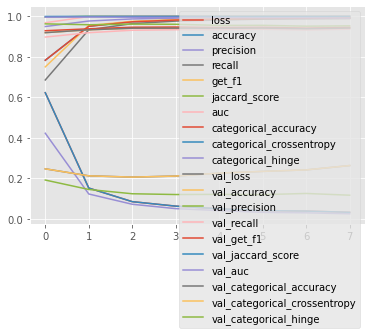

In [ ]:
%%time
plt.style.use('ggplot')
graph_data.plot()